# Manipuler des données avec Pandas



# 1. Introduction

Dans ce notebook, nous allons combiner plusieurs sources de données. Nous allons voir que c'est une étape importante (pour donner du contexte, de la valeur, à nos données), mais aussi délicate.


L’un des apports des outils modernes de *data science* comme `Pandas` est la simplicité par laquelle ils permettent de restructurer des sources pour travailler sur plusieurs données sur un projet.

On va explorer principalement deux types d’opérations:

-   les statistiques descriptives par groupe ;
-   l’association de données par des caractéristiques communes.

Effectuer ce travail de manière simple, fiable et efficace est indispensable pour les *data scientists* tant cette tâche est courante. Heureusement `Pandas` permet de faire cela très bien avec des données structurées. Évidemment, c'est moins simple (mais possible) avec des données moins/peu structurées.

Nous allons approfondir notre compréhension d’un phénomène réel par le biais de statistiques descriptives fines. Cela est une étape indispensable avant de basculer vers la [statistique inférentielle](https://fr.wikipedia.org/wiki/Inf%C3%A9rence_statistique#:~:text=L'inf%C3%A9rence%20statistique%20est%20l,%3A%20la%20probabilit%C3%A9%20d'erreur.), l’approche qui consiste à formaliser et généraliser des liens de corrélation ou de causalité entre des caractéristiques observées et un phénomène, que vous aborderez cette année.


## 1.1 Environnement

Nous allons utiliser une librairie nommée `pynsee` pour récupérer les données de l’Insee utiles à enrichir notre jeu de données de l’Ademe. Cette librairie n’est pas installée par défaut dans `Python`. Avant de pouvoir l’utiliser,
il est nécessaire de l’installer, comme la librairie `great_tables`.

In [57]:
!pip install xlrd
!pip install pynsee
!pip install great_tables

L’instruction `!pip install <pkg>` est une manière de faire comprendre à `Jupyter`, le moteur d’exécution derrière les *notebooks* que la commande qui suit (`pip install` ce `<pkg>`)
est une commande système, à exécuter hors de `Python` (dans le terminal par exemple pour un système `Linux`).

Les premiers *packages* indispensables pour démarrer sont les suivants:

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pynsee
import pynsee.download

Pour obtenir des résultats reproductibles, on peut fixer la racine du générateur
pseudo-aléatoire.

In [59]:
np.random.seed(123)

## 1.2 Données utilisées

Ce tutoriel continue l’exploration du jeu de données vue dans un autre notebook :

-   Les émissions de gaz à effet de serre estimées au niveau communal par l’ADEME. Le jeu de données est
    disponible sur [data.gouv](https://www.data.gouv.fr/fr/datasets/inventaire-de-gaz-a-effet-de-serre-territorialise/#_)
    et requêtable directement dans `Python` avec
    [cet url](https://koumoul.com/s/data-fair/api/v1/datasets/igt-pouvoir-de-rechauffement-global/convert) ;

Les problématiques d’enrichissement de données (association d’une source à une autre à partir de caractéristiques communes) seront présentées à partir de deux sources produites par l’Insee:

-   Le
    [code officiel géographique](https://www.insee.fr/fr/statistiques/fichier/6800675/v_commune_2023.csv),
    un référentiel
    produit par l’Insee utilisé pour identifier les communes à partir d’un code unique, contrairement au code postal ;
-   Les données [*Filosofi*](https://www.insee.fr/fr/metadonnees/source/serie/s1172), une source sur les revenus des Français à une échelle spatiale fine construite par l’Insee à partir des déclarations fiscales et d’informations sur les prestations sociales. En l’occurrence, nous allons utiliser les niveaux de revenu et les populations[1] au niveau communal afin de les mettre en regard de nos données d’émissions.


# 2. Récupération des jeux de données

## 2.1 Données d’émission de l’Ademe

In [60]:
import pandas as pd

url = "https://koumoul.com/s/data-fair/api/v1/datasets/igt-pouvoir-de-rechauffement-global/convert"
emissions = pd.read_csv(url)
emissions.head(2)

INSEE commune                  Commune  Agriculture  Autres transports  \
0         01001  L'ABERGEMENT-CLEMENCIAT  3711.425991                NaN   
1         01002    L'ABERGEMENT-DE-VAREY   475.330205                NaN   

   Autres transports international  CO2 biomasse hors-total     Déchets  \
0                              NaN               432.751835  101.430476   
1                              NaN               140.741660  140.675439   

    Energie  Industrie hors-énergie  Résidentiel     Routier   Tertiaire  
0  2.354558                6.911213   309.358195  793.156501  367.036172  
1  2.354558                6.911213   104.866444  348.997893  112.934207

Nous allons conserver le nom des secteurs émetteurs présents dans la base de données pour simplifier des utilisations ultérieures:

In [61]:
secteurs = emissions.select_dtypes(include='number').columns

Les exploitations ultérieures de ces données utiliseront la dimension départementale, vue précédemment :

In [62]:
emissions['dep'] = emissions["INSEE commune"].str[:2]

## 2.2 Données *Filosofi*

On va utiliser les données Filosofi (données de revenus) au niveau communal de 2016.
Ce n’est pas la même année que les données d’émission de CO2, ce n’est donc pas parfaitement rigoureux,
mais cela permettra tout de même d’illustrer
les principales fonctionnalités de `Pandas`

Le point d’entrée principal de la fonction `pynsee` est la fonction `download_file`.

Le code pour télécharger les données est le suivant :

In [63]:
from pynsee.download import download_file
filosofi = download_file("FILOSOFI_COM_2016")

Le *DataFrame* en question a l’aspect suivant :

In [64]:
filosofi.sample(3)

CODGEO       LIBGEO NBMENFISC16 NBPERSMENFISC16               MED16  \
34640  93077  Villemomble       11968         30123.5  21782.222222222223   
9988   28073    Champseru         121           326.5               24806   
17537  48190       Termes          92           210.5  19108.571428571428   

      PIMP16 TP6016 TP60AGE116 TP60AGE216 TP60AGE316  ... PPEN16 PPAT16  \
34640     61     19         22         23         19  ...   23.1      9   
9988    None   None       None       None       None  ...   None   None   
17537   None   None       None       None       None  ...   None   None   

      PPSOC16 PPFAM16 PPMINI16 PPLOGT16 PIMPOT16               D116     D916  \
34640     5.1     2.1      1.7      1.3    -19.6  9371.481481481482  40950.8   
9988     None    None     None     None     None               None     None   
17537    None    None     None     None     None               None     None   

                   RD16  
34640  4.36972532901237  
9988               None  
17537              None  

[3 rows x 29 columns]

`Pandas` a géré automatiquement les types de variables. Il le fait relativement bien, mais une vérification est toujours utile pour les variables qui ont un statut spécifique.

Pour les variables qui ne sont pas en type `float` alors qu’elles devraient l’être, on modifie leur type.

In [65]:
filosofi = (
  filosofi
  .astype(
    {c: "float" for c in filosofi.columns[2:]}
  )
)

Un simple coup d’oeil sur les données
donne une idée assez précise de la manière dont les données sont organisées.
On remarque que certaines variables de `filosofi` semblent avoir beaucoup de valeurs manquantes (secret statistique)
alors que d’autres semblent complètes.
Si on désire exploiter `filosofi`, il faut faire attention à la variable choisie.

Notre objectif à terme va être de relier l’information contenue entre ces
deux jeux de données. En effet, sinon, nous risquons d’être frustré : nous allons
vouloir en savoir plus sur les émissions de gaz carbonique mais seront très
limités dans les possibilités d’analyse sans ajout d’une information annexe
issue de `filosofi`.

# 3. Statistiques descriptives par groupe

## 3.1 Principe

Nous avons vu comment obtenir
une statistique agrégée simplement grâce à `Pandas`.
Il est néanmoins commun d’avoir des données avec des strates
intermédiaires d’analyse pertinentes: des variables géographiques, l’appartenance à des groupes socio-démographiques liés à des caractéristiques renseignées, des indicatrices de période temporelle, etc.

Pour mieux comprendre la structure de ses données, les *data scientists* sont donc souvent amenés à construire des statistiques descriptives sur des sous-groupes présents dans les données. Pour reprendre l’exemple sur les émissions, nous avions précédemment construit des statistiques d’émissions au niveau national. Mais qu’en est-il du profil d’émission des différents départements ? Pour répondre à cette question, il sera utile d’agréger nos données au niveau départemental. Ceci nous donnera une information différente du jeu de données initial (niveau communal) et du niveau le plus agrégé (niveau national).

En `SQL`, il est très simple de découper des données pour
effectuer des opérations sur des blocs cohérents et recollecter des résultats
dans la dimension appropriée.
La logique sous-jacente est celle du *split-apply-combine* qui est repris
par les langages de manipulation de données, auxquels `pandas`
[ne fait pas exception](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html).

L’image suivante, issue de
[ce site](https://unlhcc.github.io/r-novice-gapminder/16-plyr/),
représente bien la manière dont fonctionne l’approche
`split`-`apply`-`combine`:

<figure>
<img src="https://unlhcc.github.io/r-novice-gapminder/fig/12-plyr-fig1.png" alt="Split-apply-combine (Source: unlhcc.github.io)" />
<figcaption aria-hidden="true">Split-apply-combine (Source: <a href="https://unlhcc.github.io/r-novice-gapminder/16-plyr/">unlhcc.github.io</a>)</figcaption>
</figure>

En `Pandas`, on utilise `groupby` pour découper les données selon un ou
plusieurs axes (ce [tutoriel](https://realpython.com/pandas-groupby/) sur le sujet
est particulièrement utile).
L’ensemble des opérations d’agrégation (comptage, moyennes, etc.) que nous avions vues précédemment peut être mise en oeuvre par groupe.

Techniquement, cette opération consiste à créer une association
entre des labels (valeurs des variables de groupe) et des
observations. Utiliser la méthode `groupby` ne déclenche pas d’opérations avant la mise en oeuvre d’une statistique, cela créé seulement une relation formelle entre des observations et des regroupemens qui seront utilisés *a posteriori*:

In [66]:
filosofi["dep"] = filosofi["CODGEO"].str[:2]
filosofi.groupby('dep').__class__

pandas.core.groupby.generic.DataFrameGroupBy

**Bonus** : Tant qu’on n’appelle pas une action sur un `DataFrame` par groupe, du type
`head` ou `display`, `pandas` n’effectue aucune opération. On parle de
*lazy evaluation*. Par exemple, le résultat de `df.groupby('dep')` est
une transformation qui n’est pas encore évaluée :

In [67]:
filosofi.groupby('dep')

## 3.2 Illustration 1: dénombrement par groupe

Pour illustrer l’application de ce principe à un comptage, on peut **dénombrer le nombre de communes par département en 2023** (chaque année cette statistique change du fait des fusions de communes). Pour cela, il suffit de prendre le référentiel des communes françaises issu du code officiel géographique (COG) et dénombrer par département grâce à `count`:

In [68]:
import requests
from io import StringIO
import pandas as pd

url_cog_2023 = "https://www.insee.fr/fr/statistiques/fichier/6800675/v_commune_2023.csv"
url_backup = "https://minio.lab.sspcloud.fr/lgaliana/data/python-ENSAE/cog_2023.csv"

# Try-except clause to avoid timout issue sometimes
# Without timeout problem, pd.read_csv(url_cog_2023) would be sufficient
try:
  response = requests.get(url_cog_2023)
  response.raise_for_status()
  cog_2023 = pd.read_csv(StringIO(response.text))
except requests.exceptions.Timeout:
  print("Failing back to backup")
  cog_2023 = pd.read_csv(url_backup)

Grâce à ce jeu de données, sans avoir recours aux statistiques par groupe, on peut déjà savoir combien on a, respectivement, de communes, départements et régions en France:

In [69]:
communes = cog_2023.loc[cog_2023['TYPECOM']=="COM"]
communes.loc[:, ['COM', 'DEP', 'REG']].nunique()

COM    34945
DEP      101
REG       18
dtype: int64

Maintenant, intéressons nous aux départements ayant le plus de communes. Il s’agit de la même fonction de dénombrement où on joue, cette fois, sur le groupe à partir duquel est calculé la statistique.

Calculer cette statistique se fait de manière assez transparente lorsqu’on connaît le principe d’un calcul de statistiques avec `Pandas`:

In [70]:
communes = cog_2023.loc[cog_2023['TYPECOM']=="COM"]
communes.groupby('DEP').agg({'COM': 'nunique'})

COM
DEP     
01   392
02   798
03   317
04   198
05   162
..   ...
971   32
972   34
973   22
974   24
976   17

[101 rows x 1 columns]

En SQL, on utiliserait la requête suivante:

``` sql
SELECT dep, COUNT DISTINCT "COM" AS COM
FROM communes
GROUP BY dep
WHERE TYPECOM == 'COM';
```

La sortie est une `Serie` indexée. Ce n’est pas très pratique, il est plus pratique de transformer cet objet en `DataFrame` avec `reset_index`. Enfin, avec `sort_values`, on obtient la statistique désirée:

In [71]:
(
    communes
    .groupby('DEP')
    .agg({'COM': 'nunique'})
    .reset_index()
    .sort_values('COM', ascending = False)
)

DEP  COM
62    62  890
1     02  798
80    80  772
57    57  725
76    76  708
..   ...  ...
96   971   32
99   974   24
98   973   22
100  976   17
75    75    1

[101 rows x 2 columns]

## 3.3 Illustration 2: agrégats par groupe

Pour illustrer les agrégats par groupe nous pouvons prendre le jeu de données de l’Insee `filosofi` et compter la population grâce à la variable `NBPERSMENFISC16`.

Pour calculer le total au niveau France entière nous pouvons faire de deux manières :

In [72]:
filosofi['NBPERSMENFISC16'].sum()* 1e-6

np.float64(66.9322415)

In [73]:
filosofi.agg({"NBPERSMENFISC16": "sum"}).div(1e6)

NBPERSMENFISC16    66.932242
dtype: float64

où les résultats sont reportés en millions de personnes. La logique est identique lorsqu’on fait des statistiques par groupe, il s’agit seulement de remplacer `filosofi` par `filosofi.groupby('dep')` pour créer une version partitionnée par département de notre jeu de données:

In [74]:
filosofi.groupby('dep')['NBPERSMENFISC16'].sum()

dep
01     613088.0
02     514249.0
03     329435.0
04     156537.5
05     133992.5
        ...    
92    1583682.0
93    1586664.5
94    1345977.0
95    1226059.0
97    1191947.0
Name: NBPERSMENFISC16, Length: 97, dtype: float64

In [75]:
filosofi.groupby('dep').agg({"NBPERSMENFISC16": "sum"})

NBPERSMENFISC16
dep                 
01          613088.0
02          514249.0
03          329435.0
04          156537.5
05          133992.5
..               ...
92         1583682.0
93         1586664.5
94         1345977.0
95         1226059.0
97         1191947.0

[97 rows x 1 columns]

La seconde approche est plus pratique car elle donne directement un `DataFrame` `Pandas` et non une série indexée sans nom. A partir de celle-ci, quelques manipulations basiques peuvent suffire pour avoir un tableau diffusables sur la démographie départementale. Néanmoins, celui-ci, serait quelques peu brut de décoffrage car nous ne possédons à l’heure actuelle que les numéros de département. Pour avoir le nom de départements, il faudrait utiliser une deuxième base de données et croiser les informations communes entre elles (en l’occurrence le numéro du département). C’est l’objet de la prochaine partie.

## 3.4 Exercice d’application

Cet exercice d’application s’appuie sur le jeu de données de l’Ademe nommé `emissions` précédemment.

### Exercice 1 : agrégations par groupe

1. Calculer les émissions totales du secteur "Résidentiel" par département et rapporter la valeur au département le plus polluant dans le domaine. En tirer des intutitions sur la réalité que cette statistique reflète.

2. Calculer, pour chaque département, les émissions totales de chaque secteur. Pour chaque département, calculer la proportion des émissions totales venant de chaque secteur.  


Grâce à ces statistiques on progresse dans la connaissance de notre jeu de données et donc de la nature des émissions de C02 en France : ces statistiques descriptives par groupe nous permettent de mieux saisir l’hétérogénéité spatiale de notre phénomène.

Cependant, on reste limité dans notre capacité à interpréter les statistiques obtenues sans recourir à l’utilisation d’information annexe. Pour donner du sens et de la valeur à une statistique, il faut généralement associer celle-ci à de la connaissance annexe sous peine qu’elle soit désincarnée.



La suite : 
nous envisagerons une première voie qui est le croisement avec des données complémentaires. On appelle ceci un enrichissement de données. Ces données peuvent être des observations à un niveau identique à celui de la source d’origine. Par exemple, l’un des croisements les plus communs est d’associer une base client à une base d’achats afin de mettre en regard un comportement d’achat avec des caractéristiques pouvant expliquer celui-ci. Les associations de données peuvent aussi se faire à des niveaux conceptuels différents, en général à un niveau plus agrégé pour contextualiser la donnée plus fine et comparer une observation à des mesures dans un groupe similaire. Par exemple, on peut associer des temps et des modes de transports individuels à ceux d’une même classe d’âge ou de personnes résidant dans la même commune pour pouvoir comparer la différence entre certains individus et un groupe sociodémographique similaire.



# 4. Restructurer les données

## 4.1 Principe

Quand on a plusieurs informations pour un même individu ou groupe, on
retrouve généralement deux types de structure de données :

-   format **wide** : les données comportent des observations répétées, pour un même individu (ou groupe), dans des colonnes différentes
-   format **long** : les données comportent des observations répétées, pour un même individu, dans des lignes différentes avec une colonne permettant de distinguer les niveaux d’observations

Un exemple de la distinction entre les deux peut être pris à l’ouvrage de référence d’Hadley Wickham, [*R for Data Science*](https://r4ds.hadley.nz/):

<figure>
<img src="https://d33wubrfki0l68.cloudfront.net/3aea19108d39606bbe49981acda07696c0c7fcd8/2de65/images/tidy-9.png" alt="Données long et wide (Source: R for Data Science)" />
<figcaption aria-hidden="true">Données <em>long</em> et <em>wide</em> (Source: <a href="https://r4ds.hadley.nz/"><em>R for Data Science</em></a>)</figcaption>
</figure>

L’aide mémoire suivante aidera à se rappeler les fonctions à appliquer si besoin :

![](https://minio.lab.sspcloud.fr/lgaliana/generative-art/pythonds/reshape.png)

Le fait de passer d’un format *wide* au format *long* (ou vice-versa)
peut être extrêmement pratique car certaines fonctions sont plus adéquates sur une forme de données ou sur l’autre.

En règle générale, avec `Python` comme avec `R`, les **formats *long* sont souvent préférables**.
Les formats *wide* sont plutôt pensés pour des tableurs comme `Excel` ou on dispose d’un nombre réduit
de lignes à partir duquel faire des tableaux croisés dynamiques.



## 4.2 Exercice d’application

Les données de l’ADEME, et celles de l’Insee également, sont au format
*wide*.
Le prochain exercice illustre l’intérêt de faire la conversion *long* $\to$ *wide*
avant de faire un graphique avec la méthode `plot`.


### Restructurer les données : wide to long

1. Créer une copie des données de l'ADEME en faisant `df_wide = emissions_wide.copy()`
2. Restructurer les données au format long pour avoir des données d'émissions par secteur en gardant comme niveau d'analyse la commune (attention aux autres variables identifiantes).
3. Faire la somme par secteur et représenter graphiquement
4. Garder, pour chaque département, le secteur le plus polluant




# 5. Joindre des données

## 5.1 Principe

Nous allons ici nous focaliser sur le cas le plus favorable qui est la situation
où une information permet d’apparier de manière exacte deux bases de données[1].
C’est un besoin quotidien des *data scientists* d’associer des informations présentes dans plusieurs fichiers. Par exemple, dans des bases de données d’entreprises, les informations clients (adresse, âge, etc.) seront dans un fichier, les ventes dans un autre et les caractéristiques des produits dans un troisième fichier. Afin d’avoir une base complète mettant en regard toutes ces informations, il sera dès lors nécessaire de joindre ces trois fichiers sur la base d’informations communes.

Cette pratique découle du fait que de nombreux systèmes d’information prennent la forme d’un schéma en étoile:

<figure>
<img src="https://www.databricks.com/wp-content/uploads/2022/04/star-schema-erd.png" alt="Illustration du schéma en étoile (Source: Databricks)" />
<figcaption aria-hidden="true">Illustration du schéma en étoile (Source: <a href="https://www.databricks.com/wp-content/uploads/2022/04/star-schema-erd.png">Databricks</a>)</figcaption>
</figure>

Cette structuration de l’information est très liée au modèle des tables relationnelles des années 1980. Aujourd’hui, il existe des modèles de données plus flexibles où l’information est empilée dans un *data lake* sans structure *a priori*. Néanmoins ce modèle du schéma en étoile conserve une pertinence parce qu’il permet de partager l’information qu’à ceux qui en ont besoin laissant le soin à ceux qui ont besoin de lier des données entre elles de le faire.

Puisque la logique du schéma en étoile vient historiquement des bases relationnelles, il est naturel qu’il s’agisse d’une approche intrinsèquement liée à la philosophie du SQL, jusque dans le vocabulaire. On parle souvent de jointure de données, un héritage du terme `JOIN` de SQL, et la manière de décrire les jointures (*left join*, *right join*…) est directement issue des instructions SQL associées.

On parle généralement de base de gauche et de droite pour illustrer les jointures.


## 5.2 Mise en oeuvre avec `Pandas`

En `Pandas`, la méthode la plus pratique pour associer des jeux de données à partir de caractéristiques communes est `merge`. Ses principaux arguments permettent de contrôler le comportement de jointure. Nous allons les explorer de manière visuelle.

En l’occurrence, pour notre problématique de construction de statistiques
sur les émissions de gaz carbonique, la base de gauche sera le *DataFrame* `emission` et la base de droite le *DataFrame* `filosofi`:

In [76]:
emissions.head(2)

INSEE commune                  Commune  Agriculture  Autres transports  \
0         01001  L'ABERGEMENT-CLEMENCIAT  3711.425991                NaN   
1         01002    L'ABERGEMENT-DE-VAREY   475.330205                NaN   

   Autres transports international  CO2 biomasse hors-total     Déchets  \
0                              NaN               432.751835  101.430476   
1                              NaN               140.741660  140.675439   

    Energie  Industrie hors-énergie  Résidentiel     Routier   Tertiaire dep  
0  2.354558                6.911213   309.358195  793.156501  367.036172  01  
1  2.354558                6.911213   104.866444  348.997893  112.934207  01

In [77]:
filosofi.head(2)

CODGEO                   LIBGEO  NBMENFISC16  NBPERSMENFISC16         MED16  \
0  01001  L'Abergement-Clémenciat        313.0            795.5  22679.000000   
1  01002    L'Abergement-de-Varey        101.0            248.0  24382.083333   

   PIMP16  TP6016  TP60AGE116  TP60AGE216  TP60AGE316  ...  PPAT16  PPSOC16  \
0     NaN     NaN         NaN         NaN         NaN  ...     NaN      NaN   
1     NaN     NaN         NaN         NaN         NaN  ...     NaN      NaN   

   PPFAM16  PPMINI16  PPLOGT16  PIMPOT16  D116  D916  RD16  dep  
0      NaN       NaN       NaN       NaN   NaN   NaN   NaN   01  
1      NaN       NaN       NaN       NaN   NaN   NaN   NaN   01  

[2 rows x 30 columns]

On parle de clé(s) de jointure pour nommer la ou les variable(s) nécessaire(s) à la fusion de données. Ce sont les variables communes aux deux jeux de données. Il n’est pas nécessaire qu’elles aient le même nom en revanche elles doivent partager des valeurs communes autrement l’intersection entre ces deux bases est l’ensemble vide.

On peut jouer sur deux dimensions dans la jointure (ceci sera plus clair ensuite avec les exemples graphiques).

-   Il existe principalement trois types de fusions: *left join* et *right join* ou un combo des deux selon le type de pivot qu’on désire mettre en oeuvre.
-   Ensuite, il existe deux manières de fusionner les valeurs une fois qu’on a choisi un pivot: *inner* ou *outer join*. Dans le premier cas, on ne conserve que les observations où les clés de jointures sont présentes dans les deux bases, dans le second on conserve toutes les observations de la clé de jointure des variables pivot quitte à avoir des valeurs manquantes si la deuxième base de données n’a pas de telles observations.

Dans les exemples ci-dessous, nous allons utiliser les codes communes et les départements comme variables de jointure. En soi, l’usage du département n’est pas nécessaire puisqu’il se déduit directement du code commune mais cela permet d’illustrer le principe des jointures sur plusieurs variables. A noter que le nom de la commune est volontairement mis de côté pour effectuer des jointures alors que c’est une information commune aux deux bases. Cependant, comme il s’agit d’un champ textuel, dont le formattage peut suivre une norme différente dans les deux bases, ce n’est pas une information fiable pour faire une jointure exacte.

Pour illustrer le principe du pivot à gauche ou à droite, on va créer deux variables identificatrices de la ligne de nos jeux de données de gauche et de droite. Cela nous permettra de trouver facilement les lignes présentes dans un jeu de données mais pas dans l’autre.

In [78]:
emissions = emissions.reset_index(names = ['id_left'])
filosofi = filosofi.reset_index(names = ['id_right'])

### 5.2.1 *Left join*

Commençons avec la jointure à gauche. Comme son nom l’indique, on va prendre la variable de gauche en pivot:

![](https://minio.lab.sspcloud.fr/lgaliana/python-ENSAE/inputs/merge_pandas/left_join.png)

In [79]:
left_merged = emissions.merge(
  filosofi,
  left_on = ["INSEE commune", "dep"],
  right_on = ["CODGEO", "dep"],
  how = "left"
)
left_merged.head(3)

id_left INSEE commune                  Commune  Agriculture  \
0        0         01001  L'ABERGEMENT-CLEMENCIAT  3711.425991   
1        1         01002    L'ABERGEMENT-DE-VAREY   475.330205   
2        2         01004        AMBERIEU-EN-BUGEY   499.043526   

   Autres transports  Autres transports international  \
0                NaN                              NaN   
1                NaN                              NaN   
2         212.577908                              NaN   

   CO2 biomasse hors-total      Déchets     Energie  Industrie hors-énergie  \
0               432.751835   101.430476    2.354558                6.911213   
1               140.741660   140.675439    2.354558                6.911213   
2             10313.446515  5314.314445  998.332482             2930.354461   

   ...  PPEN16  PPAT16  PPSOC16 PPFAM16  PPMINI16 PPLOGT16 PIMPOT16  \
0  ...     NaN     NaN      NaN     NaN       NaN      NaN      NaN   
1  ...     NaN     NaN      NaN     NaN       NaN      NaN      NaN   
2  ...    27.0     8.8      6.9     2.8       2.1      2.0    -15.7   

           D116          D916      RD16  
0           NaN           NaN       NaN  
1           NaN           NaN       NaN  
2  10457.083333  33880.555556  3.239962  

[3 rows x 44 columns]

Il est recommandé de toujours expliciter les clés de jointures par le biais des arguments `left_on`, `right_on` ou `on` si les noms de variables sont communs dans les deux bases.
Si on a des noms de variables communes entre les bases mais qu’elles ne sont pas définies comme clés de jointures, celles-ci ne seront pas utilisées pour joindre mais seront conservées avec un suffixe qui par défaut est `_x` et `_y` (paramétrable par le biais de l’argument `suffixes`).

La syntaxe `Pandas` étant directement inspirée de SQL, on a une traduction assez transparente de l’instruction ci-dessus en SQL:

``` sql
SELECT *
FROM emissions
LEFT JOIN filosofi
  ON emissions.`INSEE commune` = filosofi.CODGEO
  AND emissions.dep = filosofi.dep;
```

En faisant une jointure à gauche, on doit en principe avoir autant de lignes que la base de données à gauche:

In [80]:
left_merged.shape[0] == emissions.shape[0]

True

Autrement, cela est signe qu’il y a une clé dupliquée à droite. Grâce à notre variable `id_right`, on peut savoir les codes communes à droite qui n’existent pas à gauche:

In [81]:
left_merged.loc[left_merged['id_right'].isna()].tail(3)

id_left INSEE commune        Commune  Agriculture  Autres transports  \
35348    35348         91182  COURCOURONNES    24.548795         103.360309   
35360    35360         91222      ESTOUCHES  1790.002871                NaN   
35687    35687         95259     GADANCOURT   312.298700                NaN   

       Autres transports international  CO2 biomasse hors-total     Déchets  \
35348                              NaN              9623.065698  111.241872   
35360                              NaN               113.797978   30.548162   
35687                              NaN               142.113291   11.372909   

           Energie  Industrie hors-énergie  ...  PPEN16  PPAT16  PPSOC16  \
35348  1276.170296             3745.877636  ...     NaN     NaN      NaN   
35360     2.354558                6.911213  ...     NaN     NaN      NaN   
35687          NaN                     NaN  ...     NaN     NaN      NaN   

      PPFAM16  PPMINI16 PPLOGT16 PIMPOT16  D116  D916  RD16  
35348     NaN       NaN      NaN      NaN   NaN   NaN   NaN  
35360     NaN       NaN      NaN      NaN   NaN   NaN   NaN  
35687     NaN       NaN      NaN      NaN   NaN   NaN   NaN  

[3 rows x 44 columns]

Cela vient du fait que nous utilisons des données qui ne sont pas de la même année de référence du code officiel géographique (2016 vs 2018). Pendant cet intervalle, il y a eu des changements de géographie, notamment des fusions de communes. Par exemple, la commune de Courcouronnes qu’on a vu ci-dessus peut être retrouvée regroupée avec Evry dans le jeu de données filosofi (base de droite):

In [82]:
filosofi.loc[
  filosofi['LIBGEO']
  .str.lower()
  .str.contains("courcouronnes")
]

id_right CODGEO              LIBGEO  NBMENFISC16  NBPERSMENFISC16  \
34441     34441  91228  Évry-Courcouronnes      23761.0          65184.5   

         MED16  PIMP16  TP6016  TP60AGE116  TP60AGE216  ...  PPAT16  PPSOC16  \
34441  17107.0    47.0    26.0        30.0        26.0  ...     4.0     10.5   

       PPFAM16  PPMINI16  PPLOGT16  PIMPOT16         D116     D916      RD16  \
34441      4.4       3.1       2.9     -15.0  9139.090909  30888.0  3.379767   

       dep  
34441   91  

[1 rows x 31 columns]

Dans un exercice de construction de statistiques publiques, on ne pourrait donc se permettre cette disjonction des années.

### 5.2.2 *Right join*

![](https://minio.lab.sspcloud.fr/lgaliana/python-ENSAE/inputs/merge_pandas/right_join.png)

Le principe est le même mais cette fois c’est la base de droite qui est prise sous forme de pivot:

In [83]:
right_merged = emissions.merge(
  filosofi,
  left_on = ["INSEE commune", "dep"],
  right_on = ["CODGEO", "dep"],
  how = "right"
)
right_merged.head(3)

id_left INSEE commune                  Commune  Agriculture  \
0      0.0         01001  L'ABERGEMENT-CLEMENCIAT  3711.425991   
1      1.0         01002    L'ABERGEMENT-DE-VAREY   475.330205   
2      2.0         01004        AMBERIEU-EN-BUGEY   499.043526   

   Autres transports  Autres transports international  \
0                NaN                              NaN   
1                NaN                              NaN   
2         212.577908                              NaN   

   CO2 biomasse hors-total      Déchets     Energie  Industrie hors-énergie  \
0               432.751835   101.430476    2.354558                6.911213   
1               140.741660   140.675439    2.354558                6.911213   
2             10313.446515  5314.314445  998.332482             2930.354461   

   ...  PPEN16  PPAT16  PPSOC16 PPFAM16  PPMINI16 PPLOGT16 PIMPOT16  \
0  ...     NaN     NaN      NaN     NaN       NaN      NaN      NaN   
1  ...     NaN     NaN      NaN     NaN       NaN      NaN      NaN   
2  ...    27.0     8.8      6.9     2.8       2.1      2.0    -15.7   

           D116          D916      RD16  
0           NaN           NaN       NaN  
1           NaN           NaN       NaN  
2  10457.083333  33880.555556  3.239962  

[3 rows x 44 columns]

L’instruction équivalente en SQL serait

``` sql
SELECT *
FROM filosofi
RIGHT JOIN emissions
  ON filosofi.CODGEO = emissions.`INSEE commune`
  AND filosofi.dep = emissions.dep;
```

On peut, comme précédemment, vérifier la cohérence des dimensions:

In [84]:
right_merged.shape[0] == filosofi.shape[0]

True

Pour vérifier le nombre de lignes des données Filosofi que nous n’avons pas dans notre jeu d’émissions de gaz carbonique, on peut faire

In [85]:
right_merged['id_left'].isna().sum()

np.int64(61)

C’est un nombre faible. Quelles sont ces observations ?

In [86]:
right_merged.loc[
  right_merged['id_left'].isna(),
  filosofi.columns.tolist() + emissions.columns.tolist()
]

id_right CODGEO             LIBGEO  NBMENFISC16  NBPERSMENFISC16  \
4346       4346  13055          Marseille     362971.0         815045.5   
27115     27115  69123               Lyon     225617.0         459305.5   
29288     29288  75056              Paris    1027657.0        2074629.5   
34874     34874  97201  L'Ajoupa-Bouillon        688.0           1634.0   
34875     34875  97202  Les Anses-d'Arlet       1390.0           3274.5   
...         ...    ...                ...          ...              ...   
34927     34927  97420     Sainte-Suzanne       7827.0          23118.0   
34928     34928  97421            Salazie       2358.0           6967.0   
34929     34929  97422          Le Tampon      27916.0          73468.5   
34930     34930  97423  Les Trois-Bassins       2386.0           7105.0   
34931     34931  97424             Cilaos       2038.0           5603.0   

              MED16  PIMP16  TP6016  TP60AGE116  TP60AGE216  ...  \
4346   18248.000000    47.0    26.0        34.0        30.0  ...   
27115  22806.000000    60.0    15.0        21.0        13.0  ...   
29288  26808.000000    69.0    16.0        17.0        13.0  ...   
34874  14116.833333     NaN     NaN         NaN         NaN  ...   
34875  14645.277778    25.0    37.0         NaN         NaN  ...   
...             ...     ...     ...         ...         ...  ...   
34927  15110.666667    26.0    38.0        53.0        39.0  ...   
34928  11280.937500    12.0    58.0         NaN        63.0  ...   
34929  14243.809524    25.0    41.0        56.0        45.0  ...   
34930  14031.785714    23.0    42.0         NaN        42.0  ...   
34931  12034.375000    15.0    53.0         NaN        60.0  ...   

       Autres transports  Autres transports international  \
4346                 NaN                              NaN   
27115                NaN                              NaN   
29288                NaN                              NaN   
34874                NaN                              NaN   
34875                NaN                              NaN   
...                  ...                              ...   
34927                NaN                              NaN   
34928                NaN                              NaN   
34929                NaN                              NaN   
34930                NaN                              NaN   
34931                NaN                              NaN   

       CO2 biomasse hors-total  Déchets  Energie  Industrie hors-énergie  \
4346                       NaN      NaN      NaN                     NaN   
27115                      NaN      NaN      NaN                     NaN   
29288                      NaN      NaN      NaN                     NaN   
34874                      NaN      NaN      NaN                     NaN   
34875                      NaN      NaN      NaN                     NaN   
...                        ...      ...      ...                     ...   
34927                      NaN      NaN      NaN                     NaN   
34928                      NaN      NaN      NaN                     NaN   
34929                      NaN      NaN      NaN                     NaN   
34930                      NaN      NaN      NaN                     NaN   
34931                      NaN      NaN      NaN                     NaN   

       Résidentiel  Routier  Tertiaire  dep  
4346           NaN      NaN        NaN   13  
27115          NaN      NaN        NaN   69  
29288          NaN      NaN        NaN   75  
34874          NaN      NaN        NaN   97  
34875          NaN      NaN        NaN   97  
...            ...      ...        ...  ...  
34927          NaN      NaN        NaN   97  
34928          NaN      NaN        NaN   97  
34929          NaN      NaN        NaN   97  
34930          NaN      NaN        NaN   97  
34931          NaN      NaN        NaN   97  

[61 rows x 45 columns]

Il est suprenant de voir que Paris, Lyon et Marseille sont présents
dans la base des statistiques communales mais pas dans celles des émissions.
Pour comprendre pourquoi, recherchons dans nos données d’émissions les observations liées à Marseille:

In [87]:
emissions.loc[
  emissions["Commune"]
  .str.lower()
  .str.contains('MARSEILLE')
]

Empty DataFrame
Columns: [id_left, INSEE commune, Commune, Agriculture, Autres transports, Autres transports international, CO2 biomasse hors-total, Déchets, Energie, Industrie hors-énergie, Résidentiel, Routier, Tertiaire, dep]
Index: []

Cela vient du fait que le jeu de données des émissions de l’Ademe propose de l’information sur les arrondissements dans les trois plus grandes villes
là où le jeu de données de l’Insee ne fait pas cette décomposition.

### 5.2.3 *Inner join*

![](https://minio.lab.sspcloud.fr/lgaliana/python-ENSAE/inputs/merge_pandas/inner.png)

Il s’agit du jeu de données où les clés sont retrouvées à l’intersection des deux tables.

In [88]:
inner_merged = emissions.merge(
  filosofi,
  left_on = ["INSEE commune", "dep"],
  right_on = ["CODGEO", "dep"],
  how = "inner"
)
inner_merged.head(3)

id_left INSEE commune                  Commune  Agriculture  \
0        0         01001  L'ABERGEMENT-CLEMENCIAT  3711.425991   
1        1         01002    L'ABERGEMENT-DE-VAREY   475.330205   
2        2         01004        AMBERIEU-EN-BUGEY   499.043526   

   Autres transports  Autres transports international  \
0                NaN                              NaN   
1                NaN                              NaN   
2         212.577908                              NaN   

   CO2 biomasse hors-total      Déchets     Energie  Industrie hors-énergie  \
0               432.751835   101.430476    2.354558                6.911213   
1               140.741660   140.675439    2.354558                6.911213   
2             10313.446515  5314.314445  998.332482             2930.354461   

   ...  PPEN16  PPAT16  PPSOC16 PPFAM16  PPMINI16 PPLOGT16 PIMPOT16  \
0  ...     NaN     NaN      NaN     NaN       NaN      NaN      NaN   
1  ...     NaN     NaN      NaN     NaN       NaN      NaN      NaN   
2  ...    27.0     8.8      6.9     2.8       2.1      2.0    -15.7   

           D116          D916      RD16  
0           NaN           NaN       NaN  
1           NaN           NaN       NaN  
2  10457.083333  33880.555556  3.239962  

[3 rows x 44 columns]

En SQL, cela donne

``` sql
SELECT *
FROM emissions
INNER JOIN filosofi
  ON emissions.`INSEE commune` = filosofi.CODGEO
  AND emissions.dep = filosofi.dep;
```

Le nombre de lignes dans notre jeu de données peut être comparé au jeu de droite et de gauche:

In [89]:
inner_merged.shape[0] == (
  left_merged.shape[0] - left_merged['id_right'].isna().sum()
)

np.True_

In [90]:
inner_merged.shape[0] == (
  right_merged.shape[0] - right_merged['id_left'].isna().sum()
)

np.True_

### 5.2.4 *Full join*

Le *full join* est un pivot à gauche puis à droite pour les informations qui n’ont pas été trouvées

![](https://minio.lab.sspcloud.fr/lgaliana/python-ENSAE/inputs/merge_pandas/full_join.png)

In [91]:
full_merged = emissions.merge(
  filosofi,
  left_on = ["INSEE commune", "dep"],
  right_on = ["CODGEO", "dep"],
  how = "outer"
)
full_merged.head(3)

id_left INSEE commune                  Commune  Agriculture  \
0      0.0         01001  L'ABERGEMENT-CLEMENCIAT  3711.425991   
1      1.0         01002    L'ABERGEMENT-DE-VAREY   475.330205   
2      2.0         01004        AMBERIEU-EN-BUGEY   499.043526   

   Autres transports  Autres transports international  \
0                NaN                              NaN   
1                NaN                              NaN   
2         212.577908                              NaN   

   CO2 biomasse hors-total      Déchets     Energie  Industrie hors-énergie  \
0               432.751835   101.430476    2.354558                6.911213   
1               140.741660   140.675439    2.354558                6.911213   
2             10313.446515  5314.314445  998.332482             2930.354461   

   ...  PPEN16  PPAT16  PPSOC16 PPFAM16  PPMINI16 PPLOGT16 PIMPOT16  \
0  ...     NaN     NaN      NaN     NaN       NaN      NaN      NaN   
1  ...     NaN     NaN      NaN     NaN       NaN      NaN      NaN   
2  ...    27.0     8.8      6.9     2.8       2.1      2.0    -15.7   

           D116          D916      RD16  
0           NaN           NaN       NaN  
1           NaN           NaN       NaN  
2  10457.083333  33880.555556  3.239962  

[3 rows x 44 columns]

Comme d’habitude, la traduction en SQL est presque immédiate:

``` sql
SELECT *
FROM emissions
FULL OUTER JOIN filosofi
  ON emissions.`INSEE commune` = filosofi.CODGEO
  AND emissions.dep = filosofi.dep;
```

Cette fois, on a une combinaison de nos trois jeux de données initiaux:

-   Le *inner join* ;
-   Le *left join* sur les observations sans clé de droite ;
-   Le *right join* sur les observations sans clé de gauche ;

In [92]:
(
  full_merged['id_left'].isna().sum() + full_merged['id_right'].isna().sum()
) == (
  left_merged['id_right'].isna().sum() + right_merged['id_left'].isna().sum()
)

np.True_

## Exemples d’identifiants dans les données françaises

### Le Code officiel géographique (COG): l’identifiant des données géographiques

Pour les données géographiques, il existe de nombreux identifiants selon la problématique d’étude.
Parmi les besoins principaux, on retrouve le fait d’apparier des données géographiques à partir d’un identifiant administratif commun. Par exemple, associer deux jeux de données au niveau communal.

Pour cela, l’identifiant de référence est le code Insee, issu du [Code officiel géographique (COG)](https://www.insee.fr/fr/information/2560452).
La géographie administrative étant en évolution perpétuelle, la base des code Insee est une base vivante. Le site et les API de l’Insee permettent de récupérer l’historique d’après-guerre afin de pouvoir faire de l’analyse géographique sur longue période.

Les codes postaux ne peuvent être considérés comme un identifiant : ils peuvent regrouper plusieurs communes ou, au contraire, une même commune peut avoir plusieurs codes postaux. Il s’agit d’un système de gestion de la Poste qui n’a pas été construit pour l’analyse statistique.

Pour se convaincre du problème, à partir des données mises à disposition par La Poste, on peut voir que le code postal 11420 correspond à 11 communes:

In [93]:
codes_postaux = pd.read_csv(
  "https://datanova.laposte.fr/data-fair/api/v1/datasets/laposte-hexasmal/raw",
  sep = ";", encoding = "latin1",
  dtype = {"Code_postal": "str", "#Code_commune_INSEE": "str"}
)
codes_postaux.loc[codes_postaux['Code_postal'] == "11420"]

#Code_commune_INSEE      Nom_de_la_commune Code_postal  \
3921               11033                BELPECH       11420   
3944               11057                CAHUZAC       11420   
4080               11184                 LAFAGE       11420   
4124               11226             MAYREVILLE       11420   
4134               11236              MOLANDIER       11420   
4176               11277      PECHARIC ET LE PY       11420   
4177               11278              PECH LUNA       11420   
4182               11283  PEYREFITTE SUR L HERS       11420   
4189               11290                PLAIGNE       11420   
4264               11365              ST SERNIN       11420   
4317               11419              VILLAUTOU       11420   

     Libellé_d_acheminement Ligne_5  
3921                BELPECH     NaN  
3944                CAHUZAC     NaN  
4080                 LAFAGE     NaN  
4124             MAYREVILLE     NaN  
4134              MOLANDIER     NaN  
4176      PECHARIC ET LE PY     NaN  
4177              PECH LUNA     NaN  
4182  PEYREFITTE SUR L HERS     NaN  
4189                PLAIGNE     NaN  
4264              ST SERNIN     NaN  
4317              VILLAUTOU     NaN

Pour terminer, nous pouvons représenter le problème sous forme cartographique en prenant l’exemple de l’Aude. Le code pour produire la carte des codes communes est donné tel quel, il n’est pas développé (cela sort du cadre de ce carnet).

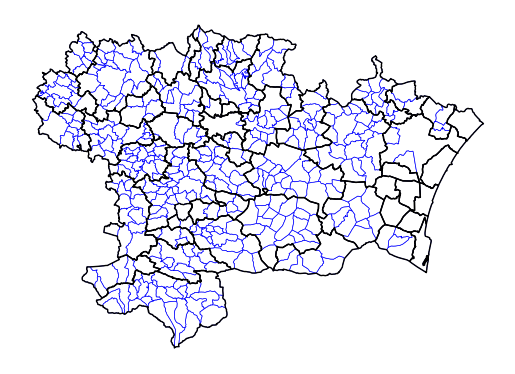

In [94]:
from cartiflette import carti_download
shp_communes = carti_download(
  values = ["11"],
  crs = 4326,
  borders = "COMMUNE",
  simplification=50,
  filter_by="DEPARTEMENT",
  source="EXPRESS-COG-CARTO-TERRITOIRE",
  year=2022)

codes_postaux11 = shp_communes.merge(
  codes_postaux,
  left_on = "INSEE_COM",
  right_on = "#Code_commune_INSEE"
)
codes_postaux11 = codes_postaux11.dissolve(by = "Code_postal")

# Carte
ax = shp_communes.plot(color='white', edgecolor='blue', linewidth = 0.5)
ax = codes_postaux11.plot(ax = ax, color='none', edgecolor='black')
ax.set_axis_off()